Week 3 Project

In [5]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import linalg
import time
import matplotlib.pyplot as plt

Problem 1

In [6]:
def exponentially_weighted_covariance_matrix(returns, lam):
    n, m = returns.shape
    weights = np.zeros((n, m))
    weights[0, :] = 1
    for i in range(1, n):
        weights[i, :] = weights[i-1, :] * lam
    weighted_returns = np.multiply(returns, weights)
    cov_matrix = np.cov(weighted_returns, rowvar=False)
    return cov_matrix

In [7]:
def plot_cumulative_variance(returns, lams):
    fig, ax = plt.subplots(figsize=(8, 6))
    for lam in lams:
        cov_matrix = exponentially_weighted_covariance_matrix(returns, lam)
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        eigenvalues = np.real(eigenvalues)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        explained_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)
        ax.plot(explained_variance, label=f"lambda={lam}")
    ax.legend()
    ax.set_xlabel("Number of Principal Components")
    ax.set_ylabel("Cumulative Variance Explained")
    plt.show()

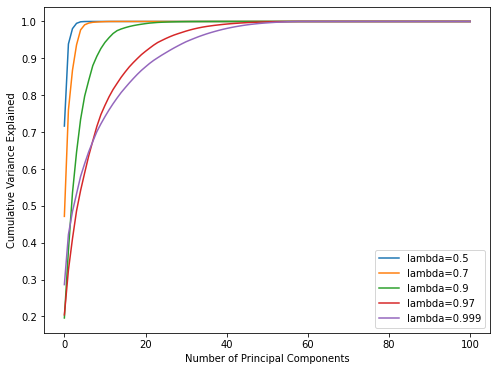

In [8]:
returns = pd.read_csv("DailyReturn.csv").iloc[:, 1:].values
lams = [0.5, 0.7, 0.9, 0.97, 0.999]
plot_cumulative_variance(returns, lams)

Problem 2

In [9]:
# Cholesky that assumes PSD
'''
from numpy.linalg import cholesky, LinAlgError

def chol_psd(matrix):
    try:
        return cholesky(matrix, lower=True)
    except LinAlgError:
        eigvals = np.linalg.eigvals(matrix)
        eigvals[eigvals < 0] = 0
        matrix = np.dot(np.dot(np.linalg.eigh(matrix)[1], np.diag(eigvals)), np.linalg.eigh(matrix)[1].T)
        return cholesky(matrix, lower=True)
'''

def chol_psd(matrix):
    n = matrix.shape[0]
    L = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1):
            s = sum(L[i][k] * L[j][k] for k in range(j))
            if (i == j):
                L[i][j] = np.sqrt(matrix[i][i] - s)
            else:
                L[i][j] = (1.0 / L[j][j] * (matrix[i][j] - s))
    return L

In [10]:
# Near PSD Matrix
def near_psd(matrix, epsilon=0):
    n = matrix.shape[0]
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    eigenvalues[eigenvalues < epsilon] = epsilon
    matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
    return matrix

In [11]:
# Higham's 2002 nearest psd correlation function
def higham(matrix):
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    eigenvalues[eigenvalues < 0] = 0
    matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
    return matrix

In [12]:
# Generate a non-psd correlation matrix
N = [100, 200, 300, 400, 500]
near_psd_time = []
higham_time = []

for n in N:
    sigma = np.full((n,n), 0.9)
    for i in range(n):
        sigma[i,i] = 1.0
    sigma[1,2] = 0.7357
    sigma[2,1] = 0.7357
    
    # Measure time for near_psd
    start_time = time.time()
    near_psd_matrix = near_psd(sigma)
    near_psd_time.append(time.time() - start_time)
    print("Time taken by near_psd for N =", n, "is:", near_psd_time[-1], "seconds")
    
    # Measure time for higham
    start_time = time.time()
    higham_matrix = higham(sigma)
    higham_time.append(time.time() - start_time)
    print("Time taken by higham for N =", n, "is:", higham_time[-1], "seconds")

Time taken by near_psd for N = 100 is: 0.0050067901611328125 seconds
Time taken by higham for N = 100 is: 0.01562809944152832 seconds
Time taken by near_psd for N = 200 is: 0.031242847442626953 seconds
Time taken by higham for N = 200 is: 0.014013528823852539 seconds
Time taken by near_psd for N = 300 is: 0.03125572204589844 seconds
Time taken by higham for N = 300 is: 0.03125262260437012 seconds
Time taken by near_psd for N = 400 is: 0.06341052055358887 seconds
Time taken by higham for N = 400 is: 0.04788684844970703 seconds
Time taken by near_psd for N = 500 is: 0.08752918243408203 seconds
Time taken by higham for N = 500 is: 0.08101415634155273 seconds


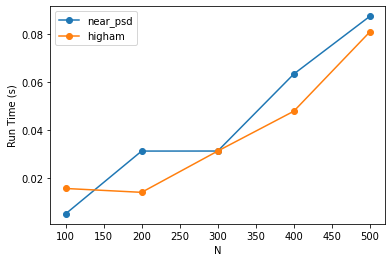

In [13]:
# Plot the results
plt.plot(N, near_psd_time, '-o', label='near_psd')
plt.plot(N, higham_time, '-o', label='higham')
plt.xlabel('N')
plt.ylabel('Run Time (s)')
plt.legend()
plt.show()

In [14]:
# Confirm that the matrix is now PSD
print("Is Near PSD Matrix PSD: ", np.all(np.linalg.eigvals(near_psd_matrix) > 0))
print("Is Higham Matrix PSD: ", np.all(np.linalg.eigvals(higham_matrix) > 0))

Is Near PSD Matrix PSD:  True
Is Higham Matrix PSD:  True


In [15]:
# Compare the results of both using the Frobenius Norm
frobenius_norm_near_psd = np.linalg.norm(near_psd_matrix - sigma, 'fro')
frobenius_norm_higham = np.linalg.norm(higham_matrix - sigma, 'fro')
print("Frobenius Norm Near PSD: ", frobenius_norm_near_psd)
print("Frobenius Norm Higham: ", frobenius_norm_higham)

Frobenius Norm Near PSD:  0.06364303890469009
Frobenius Norm Higham:  0.06364303890469009


Problem 3

In [16]:
# Import data
df = pd.read_csv("DailyReturn.csv")

In [17]:
# Define functions for calculating the standard Pearson correlation and variance
def pearson_correlation(df):
    cov_matrix = np.cov(df.T)
    cor_matrix = np.corrcoef(df.T)
    return cor_matrix

def variance(df):
    var_vector = np.var(df, axis=0)
    return var_vector

In [18]:
# Define a function for exponentially weighted variance
def exponential_weighted_variance(df, lam=0.97):
    T = df.shape[0]
    weights = np.exp(np.linspace(0, -(T-1), T)*np.log(lam))
    weighted_var = np.average(df**2, axis=0, weights=weights)
    return weighted_var

In [19]:
# Calculate the standard Pearson correlation and variance
cor_matrix_pearson = pearson_correlation(df.iloc[:, 1:])
var_vector_pearson = variance(df.iloc[:, 1:])

In [20]:
# Calculate the exponentially weighted variance
var_vector_ew = exponential_weighted_variance(df.iloc[:, 1:])

In [21]:
# Calculate 4 different covariance matrices
cov_matrix_pearson_var = np.diag(var_vector_pearson)
cov_matrix_pearson_ew = np.diag(var_vector_ew)
cov_matrix_ew_var = cor_matrix_pearson * np.sqrt(np.outer(var_vector_ew, var_vector_ew))
cov_matrix_ew_ew = cor_matrix_pearson * np.sqrt(np.outer(var_vector_ew, var_vector_ew)) * np.sqrt(np.outer(var_vector_ew, var_vector_ew))

In [22]:
# Define a function for direct simulation
def direct_simulation(cov_matrix, num_draws=25000):
    num_stocks = cov_matrix.shape[0]
    mean = np.zeros(num_stocks)
    draws = np.random.multivariate_normal(mean, cov_matrix, num_draws)
    return draws

In [23]:
# Define a function for PCA simulation
def pca_simulation(cov_matrix, explained_variance=1.0, num_draws=25000):
    num_stocks = cov_matrix.shape[0]
    mean = np.zeros(num_stocks)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[indices]
    eigenvectors = eigenvectors[:, indices]
    eigenvalues = eigenvalues[:int(explained_variance*num_stocks)]
    eigenvectors = eigenvectors[:, :int(explained_variance*num_stocks)]
    sqrt_eigenvalues = np.sqrt(eigenvalues)
    draws = np.dot(np.random.randn(num_draws, int(explained_variance*num_stocks)), np.diag(sqrt_eigenvalues))
    draws = np.dot(draws, eigenvectors.T) + mean
    return draws

In [24]:
# Read the data from the file
returns = pd.read_csv("DailyReturn.csv").iloc[:, 1:].values

In [25]:
# Calculate the mean and standard deviation of the returns
mean = np.mean(returns, axis=0)
std = np.std(returns, axis=0)

In [26]:
# Standardize the returns
returns = (returns - mean) / std

In [27]:
# Calculate the covariance matrix using standard Pearson correlation
cov_matrix_pearson = np.cov(returns.T)

In [28]:
# Calculate the covariance matrix using exponentially weighted lambda = 0.97
lambda_ = 0.97
cov_matrix_ew = np.zeros(cov_matrix_pearson.shape)
for i in range(cov_matrix_pearson.shape[0]):
    for j in range(cov_matrix_pearson.shape[1]):
        cov_matrix_ew[i, j] = lambda_ * cov_matrix_ew[i, j] + (1 - lambda_) * returns[:, i].T @ returns[:, j] / returns.shape[0]

In [29]:
# Calculate the covariance matrix using both standard Pearson correlation and variance
cov_matrix_pearson_var = np.diag(np.var(returns, axis=0))

In [30]:
# Calculate the covariance matrix using both exponentially weighted lambda = 0.97 and variance
cov_matrix_ew_var = np.diag(np.var(returns, axis=0))

In [31]:
# Define the four covariance matrices
cov_matrices = [cov_matrix_pearson, cov_matrix_ew, cov_matrix_pearson_var, cov_matrix_ew_var]

In [32]:
# Define the explained variance values for PCA simulations
explained_variances = [1, 0.75, 0.5]

In [33]:
# Define the number of draws for each simulation
num_draws = 25000

In [34]:
# Loop over the four covariance matrices
for i, cov_matrix in enumerate(cov_matrices):
    print("Covariance matrix ", i+1)
    # Direct simulation
    start_time = time.time()
    draws = np.random.multivariate_normal(mean, cov_matrix, num_draws)
    direct_sim_time = time.time() - start_time
    cov_sim = np.cov(draws, rowvar=False)
    norm = np.linalg.norm(cov_sim - cov_matrix, ord='fro')
    print("Direct simulation time: ", direct_sim_time)
    print("Covariance of simulated values: ", cov_sim)
    print("Frobenius norm (difference between simulated and input covariance matrix): ", norm)
    # Loop over the explained variances for PCA simulation
    for j, explained_variance in enumerate(explained_variances):
        start_time = time.time()
        draws = pca_simulation(cov_matrix, explained_variance, num_draws)
        pca_sim_time = time.time() - start_time
        cov_sim = np.cov(draws, rowvar=False)
        norm = np.linalg.norm(cov_sim - cov_matrix, ord='fro')
        print("PCA simulation with explained variance ", explained_variance, " time: ", pca_sim_time)
        print("Covariance of simulated values: ", cov_sim)
        print("Frobenius norm (difference between simulated and input covariance matrix): ", norm)
    print("\n")

Covariance matrix  1
Direct simulation time:  0.14704084396362305
Covariance of simulated values:  [[1.01659226 0.66039028 0.72404274 ... 0.5157096  0.56280396 0.58966774]
 [0.66039028 1.02399189 0.62263706 ... 0.22065372 0.15357825 0.29417568]
 [0.72404274 0.62263706 1.00760944 ... 0.16983852 0.08782786 0.2555911 ]
 ...
 [0.5157096  0.22065372 0.16983852 ... 1.02432637 0.51545023 0.43235655]
 [0.56280396 0.15357825 0.08782786 ... 0.51545023 1.01084606 0.32812302]
 [0.58966774 0.29417568 0.2555911  ... 0.43235655 0.32812302 1.0092048 ]]
Frobenius norm (difference between simulated and input covariance matrix):  0.5952032064753078
PCA simulation with explained variance  1  time:  0.23853635787963867
Covariance of simulated values:  [[1.01686823-2.64189078e-27j 0.65507524-8.22686315e-11j
  0.72692972-1.42895503e-11j ... 0.51309024-1.35752385e-10j
  0.56790018-1.12367817e-10j 0.59071933-1.33586511e-10j]
 [0.65507524+8.22686315e-11j 1.01147215-1.30133158e-27j
  0.61651994+5.27405093e-11j .